# Radial Velocity Tutorial for MCMC

By Roberto Tejada (2019)

This tutorial will assume the user is familiar with the `Driver` class and is acquainted with MCMC terminology. For more information about MCMC, see the [MCMC Introduction Tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/MCMC_tutorial.html). 

We explain how to jointly fit radial velocity data and relative astrometry using the MCMC technique. First we need a set of data containing radial velocity measurements. We check the data using `read_input` and observe the `quant_type` column for radial velocity data. For more information on `orbitize.read_input.read_file()`, see the [Formatting Input Tutorial](https://orbitize.readthedocs.io/en/latest/formatting_inputs.html). 

**NOTE**: Astrometry+RV fitting currently only works with MCMC and not OFTI. It also does not account for potential gamma/jitter differences between instruments.

## Read and format data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import orbitize
from orbitize import read_input, system, priors, sampler, driver, DATADIR
import multiprocessing as mp
import pprint

data_table = read_input.read_file("{}/HD4747.csv".format(DATADIR)) # print all columns
data_table.pprint_all()

 epoch   object  quant1  quant1_err quant2 quant2_err quant_type
-------- ------ -------- ---------- ------ ---------- ----------
 366.975      0 -0.54103    0.00123    nan        nan         rv
 418.829      0 -0.40053    0.00206    nan        nan         rv
 462.752      0 -0.24094     0.0011    nan        nan         rv
 690.104      0  0.37292    0.00117    nan        nan         rv
 784.771      0  0.46223    0.00133    nan        nan         rv
 806.727      0  0.48519    0.00103    nan        nan         rv
 837.717      0  0.49395    0.00117    nan        nan         rv
 838.701      0  0.49751    0.00112    nan        nan         rv
 839.711      0  0.50187    0.00112    nan        nan         rv
 1010.12      0  0.53355    0.00135    nan        nan         rv
1012.048      0  0.53164    0.00128    nan        nan         rv
1014.102      0  0.53629     0.0016    nan        nan         rv
1050.991      0  0.52154    0.00468    nan        nan         rv
1170.748      0  0.50757 

The `quant_type` column displays the type of data each row contains: astrometry (radec or seppa), or radial velocity (rv). For astrometry, `quant1` column contains right ascension or separation, and the `quant2` column contains declination or position angle. For rv data, `quant1` contains radial velocity data in $\mathrm{km/s}$, while `quant2` is filled with `nan` to preserve the data structure. The table contains each respective error column. 

We can now initialize the `Driver` class. MCMC samplers take time to converge to absolute maxima in parameter space, and the more parameters we introduce, the longer we expect it to take.

## Create Driver Object

For joint orbital fits with RV data, we need to fit the stellar and companion masses (`m0` and `m1` respectively as separate free parameters). This differs from the astrometry-only case where fitting the total mass `mtot` suffices. We set the system keyword `fit_secondary_mass` to `True` when initializing the Driver object.

In [16]:
filename = "{}/HD4747.csv".format(DATADIR)

# system parameters
num_secondary_bodies = 1
system_mass = 0.84 # [Msol]
plx = 53.18 # [mas]
mass_err = 0.04 # [Msol]
plx_err = 0.12 # [mas]

# MCMC parameters
num_temps = 5
num_walkers = 30
num_threads = mp.cpu_count() # or a different number if you prefer

my_driver = driver.Driver(
    filename, 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    system_kwargs = {'fit_secondary_mass':True, 'tau_ref_epoch':0},
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads}
)

Since MCMC is an object in `orbitize!`, we can assign a variable to the sampler and work with this variable:

In [17]:
m = my_driver.sampler

# RV Priors

The priors for the two RV parameters, the radial velocity offset (gamma), and jitter (sigma), have default uniform prior and log uniform prior respectively. The gamma uniform prior is set between $(-5,5)$ $\mathrm{km/s}$, and the jitter log uniform prior is set for ($10^{-4},0.05$) $\mathrm{km/s}$. The prior for `m1` is a log uniform prior and is set for ($10^{-3},2.0$)$M_\odot$. The current version of orbitize addressed in this tutorial returns the stellar radial velocity only. 

**NOTE**: We may change the priors as instructed in the [Modifying Priors](https://orbitize.readthedocs.io/en/latest/tutorials/Modifying_Priors.html) tutorial:

In [18]:
# getting the system object:
sys = my_driver.system

lab = sys.param_idx

print(sys.labels)
print(sys.sys_priors)

print(vars(sys.sys_priors[lab['m1']]))

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'plx', 'gamma', 'sigma', 'm1', 'm0']
[Log Uniform, Uniform, Sine, Uniform, Uniform, Uniform, Gaussian, Uniform, Log Uniform, Log Uniform, Gaussian]
{'minval': 0.001, 'maxval': 2, 'logmin': -6.907755278982137, 'logmax': 0.6931471805599453}


In [19]:
# change the m1 prior:
sys.sys_priors[lab['m1']] = priors.LogUniformPrior(1e-4, 0.5)

print(sys.labels)
print(sys.sys_priors)
print(vars(sys.sys_priors[lab['m1']]))

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'plx', 'gamma', 'sigma', 'm1', 'm0']
[Log Uniform, Uniform, Sine, Uniform, Uniform, Uniform, Gaussian, Uniform, Log Uniform, Log Uniform, Gaussian]
{'minval': 0.0001, 'maxval': 0.5, 'logmin': -9.210340371976182, 'logmax': -0.6931471805599453}


## Running the MCMC Sampler

As noted in the [MCMC Introduction Tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/MCMC_tutorial.html), we must choose the sampler step for MCMC and can save every $nth$ sample to avoid using too much disk space using `thin`. 

In [20]:
total_orbits = 1000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 10 # steps to burn in per walker
thin = 2 # only save every 2 steps

In [21]:
m.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

/Users/Helios/orbitize/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/Helios/orbitize/orbitize/priors.py:168: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/Helios/orbitize/orbitize/priors.py:168: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/Helios/orbitize/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


Burn in complete
30/34 steps completed
Run complete


Now we can plot the distribution of MCMC parameter of interest:

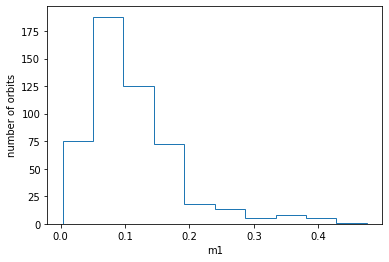

In [22]:
accepted_m1 = m.results.post[:, lab['m1']]
plt.hist(accepted_m1,histtype='step')
plt.xlabel('m1'); plt.ylabel('number of orbits')
plt.show()

# Saving Results over Extended MCMC Run

Sometimes our MCMC run will need to run for an extended period of time to let the walkers converge. To observe the convergence, we often need to see the walkers' progress along parameter space. We can save the sampler results periodically and keep running the sampler until convergence. To run for a greater number of steps and periodically save the results, we can create a for-loop and run for as many iterations as we'd like.  

In [23]:
filename = "{}/HD4747.csv".format(DATADIR)

total_orbits = 1000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 10 # steps to burn in per walker
thin = 2 # only save every 10th step

# system parameters
num_secondary_bodies = 1
system_mass = 0.84 # [Msol]
plx = 53.18 # [mas]
mass_err = 0.04 # [Msol]
plx_err = 0.12 # [mas]

# MCMC parameters
num_temps = 5
num_walkers = 30
num_threads = mp.cpu_count() # or a different number if you prefer


my_driver = driver.Driver(
    filename, 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    system_kwargs = {'fit_secondary_mass':True, 'tau_ref_epoch':0},
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads}
)

m = my_driver.sampler

We're now ready for the loop! The `results` object contains a `save_results` function which lets us save the results for our directory, and we will use the `load_results` object from `results` to access the data later. We also define the `n_iter` below to mark how many MCMC runs to save our within results. 

**NOTE**: To avoid long convergence periods, we may initialize the walkers in a sphere around the global minima of the parameter space as outlined in our [Modifying MCMC Initial Positions Tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/Modifying_MCMC_initial_positions.html).

In [24]:
# file name to save as:
hdf5_filename = 'my_rv_posterior_%1d.hdf5'

In [ ]:
n_iter = 2 # number of iterations
for i in range(n_iter):
    # running the sampler:
    orbits = m.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)
    myResults = m.results
    hdf5_filename = 'my_rv_posterior_%1d.hdf5' % i
    myResults.save_results(hdf5_filename) # saves results object as an hdf5 file

/Users/Helios/orbitize/orbitize/priors.py:168: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/Helios/orbitize/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/Helios/orbitize/orbitize/priors.py:168: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/Users/Helios/orbitize/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


# Plotting and Accesing Saved Results

We can plot the corner plot saved in the results object by following the steps in the [Advanced Plotting Tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/Plotting_tutorial.html):

In [ ]:
median_values = np.median(myResults.post,axis=0) # Compute median of each parameter
range_values = np.ones_like(median_values)*0.95 # Plot only 95% range for each parameter
corner_figure_median_95 = myResults.plot_corner(
    range=range_values,
    truths=median_values
)

As illustrated in the plot above, MCMC needs more time to run. We only performed two iterations in the loop to demonstrate its useage, but with increased `n_iter`, the trendplots saved in the loop and the corner plot will show how the walkers converge to absolute extrema in parameter space.

To access the saved data, we can read it into a results object as shown in the [MCMC Introduction Tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/MCMC_tutorial.html):

In [13]:
from orbitize import results

loaded_results = results.Results() # Create blank results object for loading
loaded_results.load_results('my_rv_posterior_%1d.hdf5' % (n_iter-1))

To demonstrate use of the loaded results file above, we can use the saved results to plot our orbital plots:

<Figure size 1008x432 with 0 Axes>

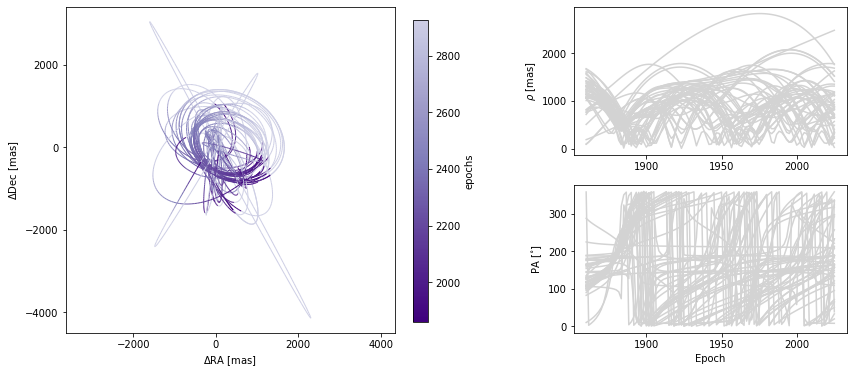

In [14]:
epochs = my_driver.system.data_table['epoch']
orbit_plot_fig = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 50, # Will plot 50 randomly selected orbits of this companion
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
)

We can pass the `rv_time_series = True` argument in `plot_orbits` to display the RV time series plot as a third panel of `plot_orbits`:

<Figure size 1008x432 with 0 Axes>

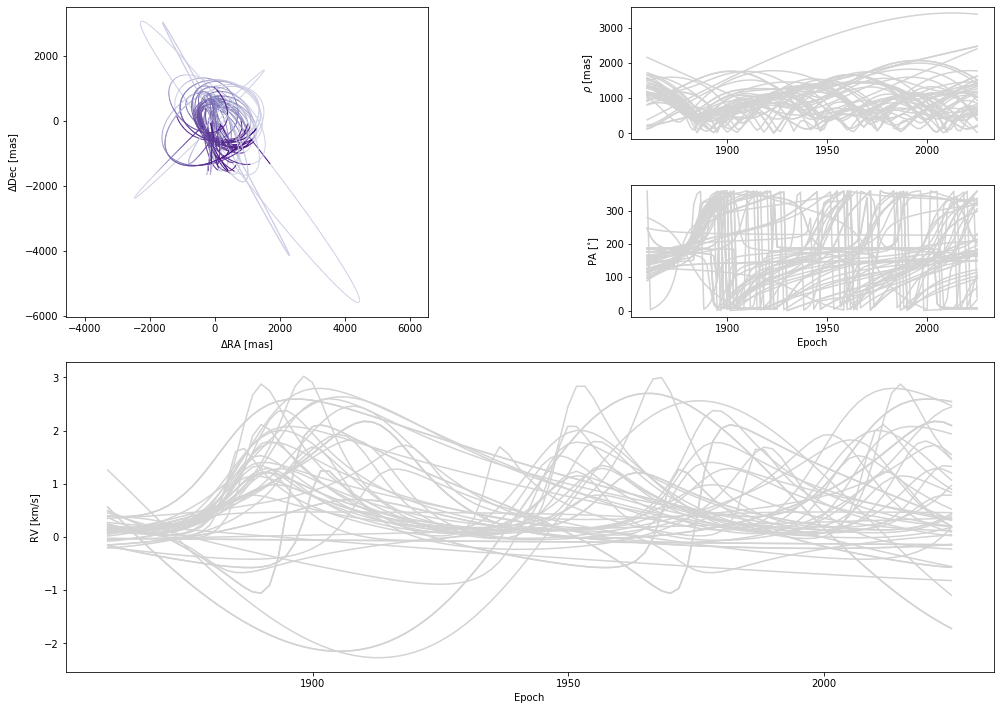

In [15]:
epochs = my_driver.system.data_table['epoch']
orbit_plot_fig = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 50, # Will plot 50 randomly selected orbits of this companion
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    rv_time_series = True
)